# 分类器

在用AutoEncoder预训练之后，Encoder已经可以对图像进行编码。这个时候是否可以回归到分类有监督学习？  
有没有方法减少标注数量，做渐进式学习？  

考虑如下分类：  
1. 杂质  
2. 血细胞  
3. 染色体  

这些分类是互斥的，使用Softmax激活。  
对于混合样本，直接丢弃。  
这里要利用Encoder+特征工程对少例分类（血细胞和杂质）进行挖掘，尽量使得分类标注比较均匀。  


### 思路一
首先考虑锁定Encoder参数，只训练分类器，同时先标注简单样本，用BinaryCrossEntropy Loss函数，从而建立起最初的特征-分类映射，作为训练的Baseline。  

此时网络在2个方面有所欠缺：  
1. 对于难样本缺乏区分能力  
2. Embedding本身的分布可能不够理想  

进一步考虑利用Baseline模型，选取难样本进行标注。同时放开Encoder参数，利用Center或Margin Loss函数，训练的目标是改善Embedding分布，提升难样本的区分能力。  
由于这个任务中，有些小染色体与杂质是比较像的，标注可能噪声较高，就不使用Focal Loss对难例进行加强训练。  

如果顺利的话，此时应该就获得了比较理想的分类模型。  
有没有办法进一步对Embedding进行监督，提高Embedding的分布质量？  
有没有办法实现增强学习？  

### 思路二

考虑直接在Embedding上进行训练，即利用Triplet Margin Loss直接计算样本对的距离。  
由于是多分类，3种分类就有9种样本对组合，需要尽量平均生成。  
这样可以改善Embedding的分布。  

猜测此时Embedding会呈现聚类效应，难例分布在概率密度较小的区域。  
由于没有加入FC等回归器，需要在Embedding训练完成后，训练GMM等聚类模型，用于分类预测。  


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import pickle
import argparse
import itertools
from datetime import datetime
import gc
import csv

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from apex import amp
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from tensorboardX import SummaryWriter
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.manifold import TSNE
from sklearn import mixture
from sklearn.utils.fixes import logsumexp

from datasets.utils import BalancedBatchSampler
from utils import AllTripletSelector, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from losses import OnlineTripletLoss
from metrics import AverageNonzeroTripletsMetric
from resnet import *
from transforms import *
from plot import *
from autoencoder import *

In [2]:
batch_size = 256 # actual batch size = 128 // 3 * 3
device = torch.device('cuda:0')
img_size = 256

data_root = '/mnt/nvme/data/chromosome'

anno_paths = [
    'neg-chunk.csv'
]

img_path = 'neg-chunk'

class_mapping = {
    'chromosome': 0,
    'cell': 1,
    'impurity': 2
}

n_classes=len(class_mapping.keys())

In [3]:
# simple dataset

class ChunkDataset(Dataset):
    def __init__(
        self,
        data_root,
        img_path,
        anno_paths,
        class_mapping,
        transform=None
    ):
        self.data_root = data_root
        self.img_path = img_path
        self.anno_paths = anno_paths
        self.class_mapping = class_mapping
        self.transform = transform
        
        self.anno_df = []
        
        for anno_path in self.anno_paths:
            anno_df = pd.read_csv(os.path.join(self.data_root, anno_path))
            self.anno_df.append(anno_df)
        
        self.anno_df = pd.concat(self.anno_df, axis=0)
        print(len(self.anno_df))
        
        self.anno_df = self.anno_df[self.anno_df['class']!='mixture']
        print(len(self.anno_df))
        
        self.labels = list(self.anno_df['class'])
        self.labels = torch.tensor([self.class_mapping[class_name] for class_name in self.labels])
        
        print(self.anno_df.head())
        
        self.total_len = len(self.anno_df)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, index):
        row = self.anno_df.iloc[index]
        img_file = os.path.join(self.data_root, self.img_path, row['filename'])
        
        img = Image.open(img_file)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, self.labels[index].item()

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    PadOrCrop(img_size),
    transforms.RandomAffine(30, translate=(0.2, 0.2), resample=PIL.Image.BILINEAR, fillcolor=255),
    transforms.ToTensor(),
    ChannelExpand()
])

train_dataset = ChunkDataset(
    data_root,
    img_path,
    anno_paths,
    class_mapping,
    transform=transform
)

train_sampler = BalancedBatchSampler(
    train_dataset.labels,
    n_classes=n_classes,
    n_samples=batch_size//n_classes
)

online_train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=8,
    pin_memory=True
)

2108
1758
                    filename     class
0  L1903012841.010.A_100.jpg  impurity
1    L1903012841.060.A_2.jpg  impurity
2   L1903012841.060.A_31.jpg  impurity
3   L1903012841.060.A_58.jpg  impurity
4    L1903012841.063.A_0.jpg  impurity


In [5]:
# create a embedding resnet

class EmbeddingNet(nn.Module):
    def __init__(self, resnet):
        super(EmbeddingNet, self).__init__()
        self.resnet = resnet
        margin = 1.
        self.criterion = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x

resnet = models.resnet34(pretrained=True)
model = EmbeddingNet(resnet)

model = model.to(device)

In [6]:
learning_rate = 1e-7
weight_decay = 1e-6
margin = 1.

# criterion = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, 12, gamma=0.1, last_epoch=-1)

metric = AverageNonzeroTripletsMetric()

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


训练记录  
Margin 1.，LR 1e-5  

* train_id 1: 包含mixture，训练了325 epoch，最终平均Loss 0.07858  

* train_id 2: 不包含mixture，训练了1000 epoch，最终平均Loss 0.02707  

* train_id 3: 不包含mixture，使用OHEM SemiHard训练1000 epoch，BatchSize由32加大到128，Loss呈现出非常稳定的状态，从0.5左右逐渐降到0.13左右（BS=32的时候Loss时常会高到10以上）。只在800 epoch的时候将LR缩小到1e-6，Loss和Metric都有明显的提升。最终的分布呈现明显的3端分离，其中血细胞分离得最好，染色体与杂质并无明显界线，但有部分染色体已经脱离杂质区域  

* train_id 4: 不包含mixture，使用OHEM Hard在train_id 3的基础上，继续训练1000 epoch，尝试初始lr=1e-6，只在800 epoch lr降低到1e-7。结果是血细胞进一步分离，已经非常理想，小的染色体和杂质依然混杂。最终平均Metric 1.363，平均Loss 0.5591  

* train_id 5: 不包含mixture，使用OHEM Hard继续在train_id 4上，Fine-tune 2000 epoch，初始LR 1e-7，在1200 epoch降到1e-8。在非常难的部分混杂减少，但是怀疑此时有过拟合嫌疑，好样本的分布似乎变差了。  

In [7]:
model.load_state_dict(torch.load('./models/EmbeddingNet_round_4.pth'))

FileNotFoundError: [Errno 2] No such file or directory: './models/EmbeddingNet_round_4.pth'

In [7]:
round_id = 1
train_id = 6
epoches = 20

In [8]:
# train

iter_count = len(online_train_loader)

writer = SummaryWriter()

model.train()

for epoch in range(epoches):
    print('epoch: {}/{}'.format(epoch+1, epoches))
    
    metric.reset()
    
    with tqdm(total=iter_count, file=sys.stdout) as pbar:
        for iter_no, (data, target) in enumerate(online_train_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
                
            optimizer.zero_grad()
            
            outputs = model(*data)
            
            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
                
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target
            
            loss_outputs = model.criterion(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
                
            #loss.backward()
            optimizer.step()

            writer.add_scalar(
                'train/loss',
                loss.item(),
                epoch*iter_count+iter_no
            )
            
            metric(outputs, target, loss_outputs)
            
            writer.add_scalar(
                'train/{}'.format(metric.name()),
                metric.value(),
                epoch*iter_count+iter_no
            )
            
            pbar.update(1)
        
        scheduler.step()
        
        if not os.path.exists('./models'):
            os.mkdir('./models')
            
        torch.save(model.state_dict(), './models/EmbeddingNet-round_{}_{}.pth'.format(round_id, train_id))

epoch: 1/20
100%|██████████| 6/6 [00:10<00:00,  1.70s/it]

/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


100%|██████████| 6/6 [00:10<00:00,  1.75s/it]
epoch: 2/20
100%|██████████| 6/6 [00:09<00:00,  1.65s/it]
epoch: 3/20
100%|██████████| 6/6 [00:09<00:00,  1.66s/it]
epoch: 4/20
100%|██████████| 6/6 [00:10<00:00,  1.67s/it]
epoch: 5/20
100%|██████████| 6/6 [00:09<00:00,  1.66s/it]
epoch: 6/20
100%|██████████| 6/6 [00:09<00:00,  1.66s/it]
epoch: 7/20
100%|██████████| 6/6 [00:10<00:00,  1.67s/it]
epoch: 8/20
100%|██████████| 6/6 [00:10<00:00,  1.69s/it]
epoch: 9/20
100%|██████████| 6/6 [00:09<00:00,  1.67s/it]
epoch: 10/20
100%|██████████| 6/6 [00:10<00:00,  1.67s/it]
epoch: 11/20
100%|██████████| 6/6 [00:10<00:00,  1.68s/it]
epoch: 12/20
100%|██████████| 6/6 [00:10<00:00,  1.68s/it]
epoch: 13/20
100%|██████████| 6/6 [00:10<00:00,  1.67s/it]
epoch: 14/20
100%|██████████| 6/6 [00:09<00:00,  1.66s/it]
epoch: 15/20
100%|██████████| 6/6 [00:09<00:00,  1.66s/it]
epoch: 16/20
100%|██████████| 6/6 [00:10<00:00,  1.68s/it]
epoch: 17/20
100%|██████████| 6/6 [00:10<00:00,  1.68s/it]
epoch: 18/20
100%|

## 分布可视化

In [7]:
val_transform = transforms.Compose([
    PadOrCrop(img_size),
    transforms.ToTensor(),
    ChannelExpand()
])

val_dataset = ChunkDataset(data_root, img_path, anno_paths, class_mapping, transform=val_transform)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

2108
1758
                    filename     class
0  L1903012841.010.A_100.jpg  impurity
1    L1903012841.060.A_2.jpg  impurity
2   L1903012841.060.A_31.jpg  impurity
3   L1903012841.060.A_58.jpg  impurity
4    L1903012841.063.A_0.jpg  impurity


In [8]:
def draw_2d(embed):
    x, y = embed.transpose()

    fig=plt.figure(figsize=(16,12))
    plt.scatter(x, y)
    plt.show()

In [9]:
cluster_num = 5
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def draw_clusters(clusters, cluster_num, embeddings, colors):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)

    for g, c in zip(range(cluster_num), colors):
        condlist = clusters == g
        cluster = np.compress(condlist, embeddings, axis=0)

        x, y = cluster.transpose()

        ax.scatter(x, y, c=c)

    plt.show()

In [10]:
PIC_SIZE = 6400

def draw_pics(embeddings, filenames):
    fig = plt.figure(figsize=(32,32))
    ax = fig.add_subplot(1, 1, 1)
    
    img = np.full((PIC_SIZE, PIC_SIZE, 3), 255)
    
    rois = []
    
    xs, ys = embeddings.transpose()
    x_max = np.max(xs)
    x_min = np.min(xs)
    y_max = np.max(ys)
    y_min = np.min(ys)
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    for embedding, filename in zip(embeddings, filenames):
        roi_img = cv2.imread(filename)
        w, h, _ = roi_img.shape
        
        x = int(((embedding[0] - x_min) / x_range) * PIC_SIZE)
        y = int(((embedding[1] - y_min) / y_range) * PIC_SIZE)
        
        if (x+w <= PIC_SIZE) and (y+h <= PIC_SIZE):
            img[x:x+w, y:y+h, ...] = roi_img
            
    ax.imshow(img)
    plt.show()
    cv2.imwrite('pic.jpg', img)

1. 现在顺次加载每个Epoch的训练模型，计算样本的分布。  

In [ ]:
for epoch in range(epoches):
    print('epoch: {}/{}'.format(epoch, epoches))
    
    model.load_state_dict(torch.load('./models/EmbeddingNet-{}-{}.pth'.format(train_id, epoch)))
    
    with torch.no_grad():
        # get epoch logits
        epoch_logits = []
        
        with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
            for imgs in val_loader:
                imgs = imgs.cuda()

                logits = model(imgs)
                logits = logits.detach().cpu()

                epoch_logits.append(logits)

                pbar.update(1)

            epoch_logits = torch.cat(epoch_logits)

            # pca
            #pca = PCA(n_components=2)
            #pca_logits = pca.fit_transform(epoch_logits)
            
            # tsne
            tsne_logits = TSNE(n_components=2).fit_transform(epoch_logits)

            # draw
            draw_2d(tsne_logits)
        

2. 看单个Epoch的分布，需要根据标签着色，以及直接叠加图像

In [35]:
model_path = './models/EmbeddingNet-4.pth'
cluster_num = 3

100%|██████████| 14/14 [00:02<00:00,  6.45it/s]

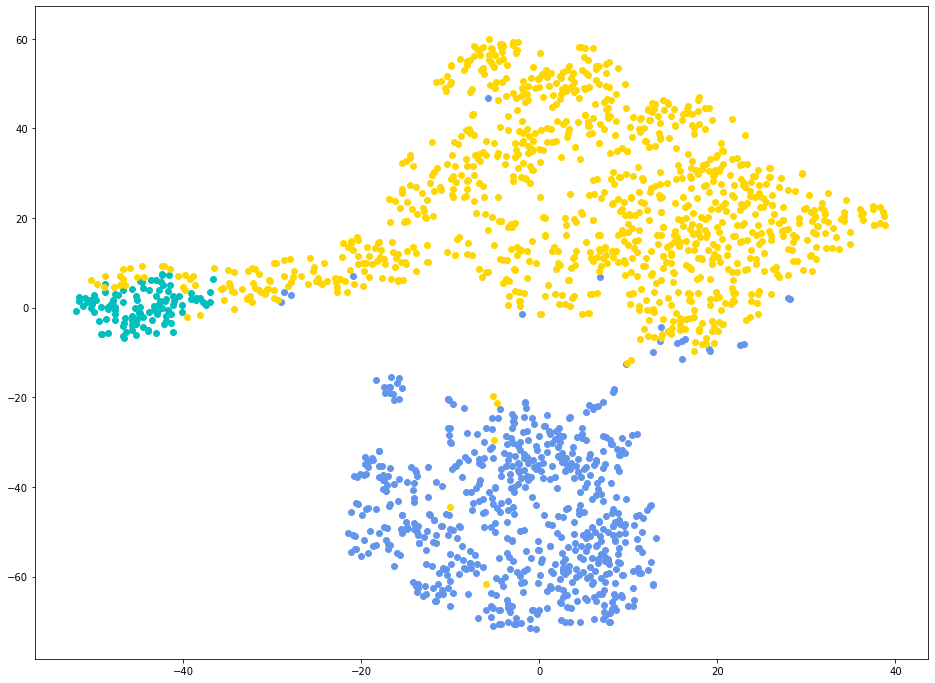

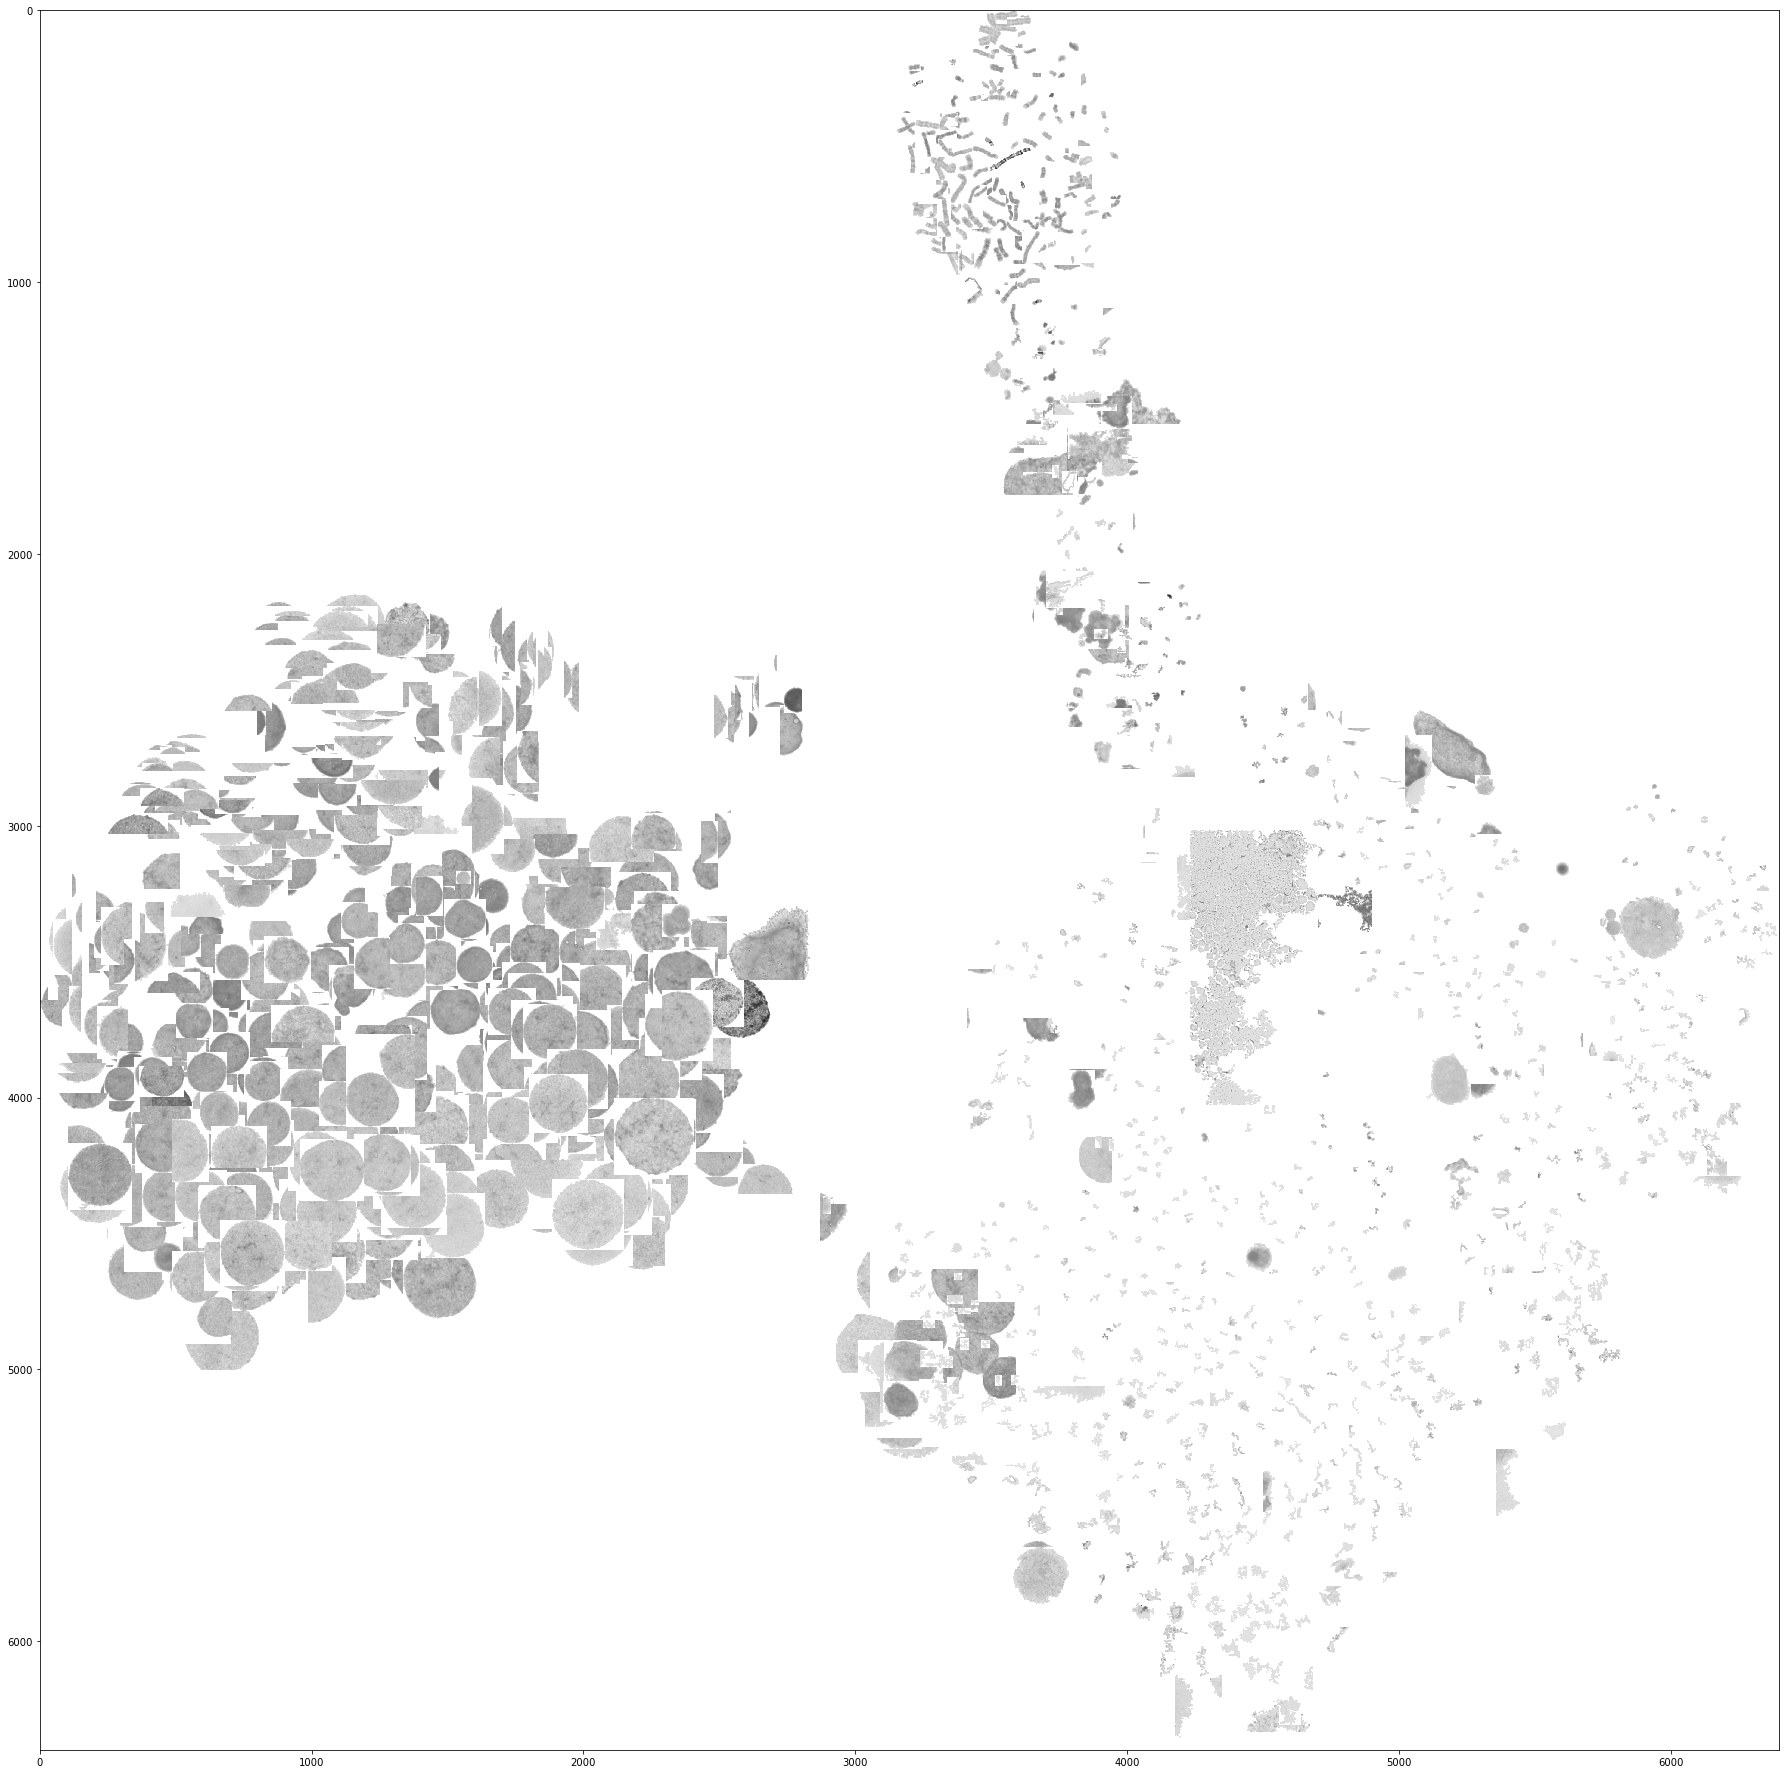

100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


In [36]:
model.load_state_dict(torch.load(model_path))

with torch.no_grad():
    # get epoch logits
    epoch_logits = []

    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for imgs, labels in val_loader:
            imgs = imgs.cuda()

            logits = model(imgs)
            logits = logits.detach().cpu()

            epoch_logits.append(logits)

            pbar.update(1)

        epoch_logits = torch.cat(epoch_logits)

        # pca
        # pca = PCA()
        # pca_logits = pca.fit_transform(epoch_logits)
        
        # tsne
        tsne_logits = TSNE(n_components=2).fit_transform(epoch_logits)

        # draw cluster
        clusters = list(val_dataset.anno_df['class'])
        clusters = np.array([class_mapping[class_name] for class_name in clusters])
        
        draw_clusters(clusters, cluster_num, tsne_logits, color_iter)
        
        # draw pic
        file_paths = list(val_dataset.anno_df['filename'])
        file_paths = [os.path.join(data_root, img_path, file_path) for file_path in file_paths]
        
        draw_pics(tsne_logits, file_paths)
        

## 分类分布

利用GMM或者QDA（QDA相当于GMM的有监督版本），拟合每个分类Embedding的高斯分布。  


In [11]:
model_path = './models/EmbeddingNet-4.pth'

In [12]:
def train_gmm(logits, labels, num_classes):
    gmms = []
    
    for class_no in range(num_classes):
        cls_logits = []
        
        for i, label in enumerate(labels):
            if label == class_no:
                cls_logits.append(logits[i])
                
        cls_logits = torch.stack(cls_logits, dim=0).cpu().numpy()

        cls_gmm = mixture.BayesianGaussianMixture(
            n_components=1,
            covariance_type='full'
        ).fit(cls_logits)
    
        gmms.append(cls_gmm)
        
    return gmms

In [13]:
# this is only experimental for now...

def sigma_density(logits, labels, num_classes, sigma=1.):
    gmms = []
    
    for class_no in range(num_classes):
        cls_logits = []
        
        for i, label in enumerate(labels):
            if label == class_no:
                cls_logits.append(logits[i])
                
        cls_logits = torch.stack(cls_logits, dim=0).cpu().numpy()

        cls_pca = PCA()
        pca_logits = cls_pca.fit_transform(cls_logits)
        
        fig = plt.figure(figsize=(16,12))
        plt.bar(range(109), cls_pca.explained_variance_ratio_)
        
        cls_gmm = mixture.BayesianGaussianMixture(
            n_components=1,
            covariance_type='full'
        ).fit(pca_logits)
    

In [14]:
model.load_state_dict(torch.load(model_path))

with torch.no_grad():
    # get epoch logits
    epoch_logits = []

    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for imgs, labels in val_loader:
            imgs = imgs.cuda()

            logits = model(imgs)
            logits = logits.detach().cpu()

            epoch_logits.append(logits)

            pbar.update(1)

        epoch_logits = torch.cat(epoch_logits)
        epoch_labels = val_dataset.labels
        

100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


In [15]:
gmms = train_gmm(epoch_logits, epoch_labels, len(class_mapping.keys()))

In [ ]:
sigma_density(epoch_logits,epoch_labels, 3, sigma=1.)

In [16]:
# simple dataset to extract unlabelled data

class UnlabelledChunkDataset(Dataset):
    def __init__(
        self,
        data_root,
        img_path,
        anno_paths,
        class_mapping,
        transform=None
    ):
        self.data_root = data_root
        self.img_path = img_path
        self.anno_paths = anno_paths
        self.class_mapping = class_mapping
        self.transform = transform
        
        self.anno_df = []
        
        for anno_path in self.anno_paths:
            anno_df = pd.read_csv(os.path.join(self.data_root, anno_path))
            self.anno_df.append(anno_df)
        
        self.anno_df = pd.concat(self.anno_df, axis=0)
        print(len(self.anno_df))
        
        self.anno_df = self.anno_df[self.anno_df['class']!='mixture']
        print(len(self.anno_df))
        
        anno_files = list(self.anno_df['filename'])
        
        files = os.listdir(os.path.join(
            self.data_root,
            self.img_path
        ))
        
        self.files = []
        
        for f in files:
            if f not in anno_files:
                self.files.append(f)
        
        print(len(self.files))
        
        self.total_len = len(self.files)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, index):
        filename = self.files[index]
        img_file = os.path.join(self.data_root, img_path, filename)
        
        img = Image.open(img_file)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img

In [17]:
test_transform = transforms.Compose([
    PadOrCrop(img_size),
    transforms.ToTensor(),
    ChannelExpand()
])

test_dataset = UnlabelledChunkDataset(
    data_root, img_path, anno_paths, class_mapping, transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

2108
1758
442526


In [18]:
def predict(gmms, logtis):        
    class_probs = []
    
    for gmm in gmms:
        probs = gmm.score_samples(logits.cpu().numpy())
        class_probs.append(probs)
        
    class_probs = np.stack(class_probs).squeeze()
    class_probs = np.transpose(class_probs, (1, 0))
    
    return class_probs

In [89]:
probs = []

with torch.no_grad():
    with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
        for imgs in test_loader:
            imgs = imgs.cuda()

            logits = model(imgs)
            logits = logits.detach().cpu()

            class_probs = predict(gmms, logits)
            probs.append(class_probs)

            pbar.update(1)
            
            '''
            for img, class_prob in zip(imgs, class_probs):
                print(np.log(-1*class_prob))

                plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
                plt.show()
            '''

100%|██████████| 3458/3458 [09:51<00:00,  5.85it/s]


In [90]:
probs = np.concatenate(probs)
class_probs = np.transpose(probs, (1, 0))

print(probs.shape)

(442526, 3)


In [91]:
def extract_info(probs, n_components):
    fig = plt.figure(figsize=(16,12))
    _, __, ___ = plt.hist(np.log(probs*-1), bins=1000)

    gmm = mixture.BayesianGaussianMixture(
        n_components=n_components,
        covariance_type='full'
    ).fit(np.nan_to_num(np.log(probs*-1)).reshape(-1, 1))

    print(gmm.means_)
    print(gmm.weights_)
    print(gmm.covariances_)
    
    return gmm

### 如何计算难例范围

#### 通用思路

考虑1维高斯分布，1、2、3倍标准差范围内，包含的概率分别为68%、95%、99.7%。  
所以可以取单向1-3倍标准差为有效范围，高斯分布重合的部分为难例区域。  

#### 特例

这里第一次标注染色体比较少，因此，可以多纳入疑似染色体，提取染色体正样本分布的0.5-5倍标准差与负样本分布的1-5倍标准差范围。  
血细胞标注比较充分，主要是有一些异形血细胞的难例存在，可以使用通用思路的选取方法。  
杂质标注是最多的，但是杂质本身情况比较复杂，考虑还是使用通用思路的选取方法。  


In [165]:
def hard_range(lower_mean, lower_var, lower_sigmas, upper_mean, upper_var, upper_sigmas):
    lower_std = np.sqrt(lower_var)[0]
    lower_start = lower_mean + lower_sigmas[0] * lower_std
    lower_end = lower_mean + lower_sigmas[1] * lower_std

    upper_std = np.sqrt(upper_var)[0]
    upper_start = upper_mean - upper_sigmas[0] * upper_std
    upper_end = upper_mean - upper_sigmas[1] * upper_std
    
    print(lower_start, lower_end, upper_start, upper_end)
    
    if lower_end < upper_end or lower_start > upper_start:
        return [0, 0]
    else:
        arr = [lower_start, lower_end, upper_start, upper_end]
        arr.sort()
        
        return [arr[1], arr[2]]

[[19.24847308]
 [21.27500387]
 [16.12692977]
 [19.17577849]]
[0.60741577 0.15855828 0.04241994 0.19160601]
[[[0.01950671]]

 [[0.06231979]]

 [[0.25567711]]

 [[1.03920304]]]


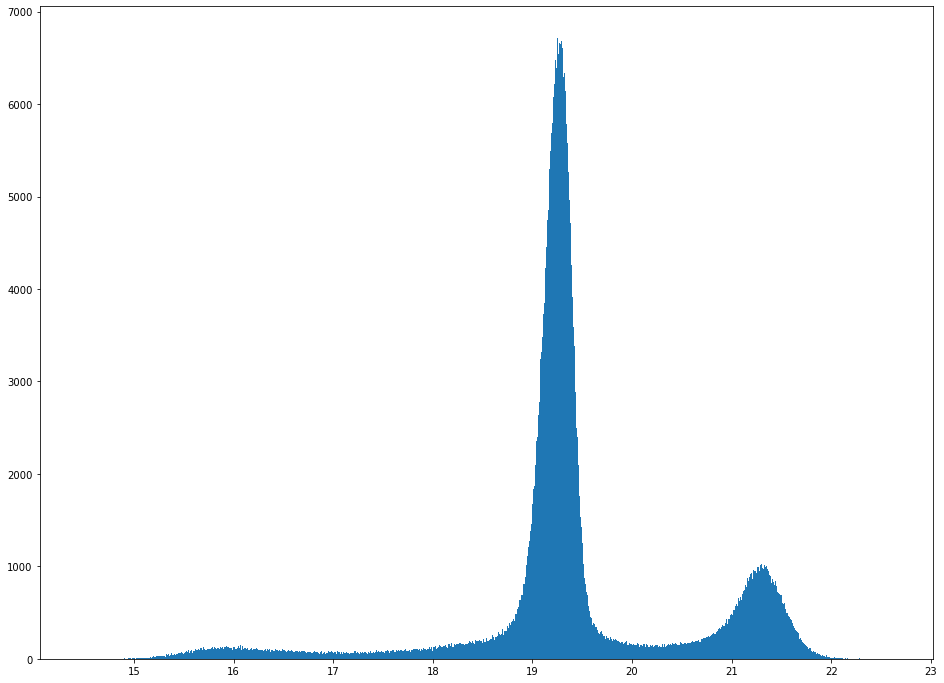

In [84]:
chromo_gmm = extract_info(class_probs[0], 4)

根据观察，16附近的是比较典型的染色体  
到19就几乎肯定不是了  

In [166]:
means = chromo_gmm.means_
variances = chromo_gmm.covariances_

chromo_range = hard_range(means[2][0], variances[2][0], [0.5, 5.], means[3][0], variances[3][0], [1., 5.])
print(chromo_range)

16.37975239342572 18.655155992708874 18.15636540552201 14.078713066307143
[16.37975239342572, 18.15636540552201]


/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


[[7.5240249 ]
 [9.92139229]]
[0.10159815 0.89840185]
[[[0.28573703]]

 [[0.54479197]]]


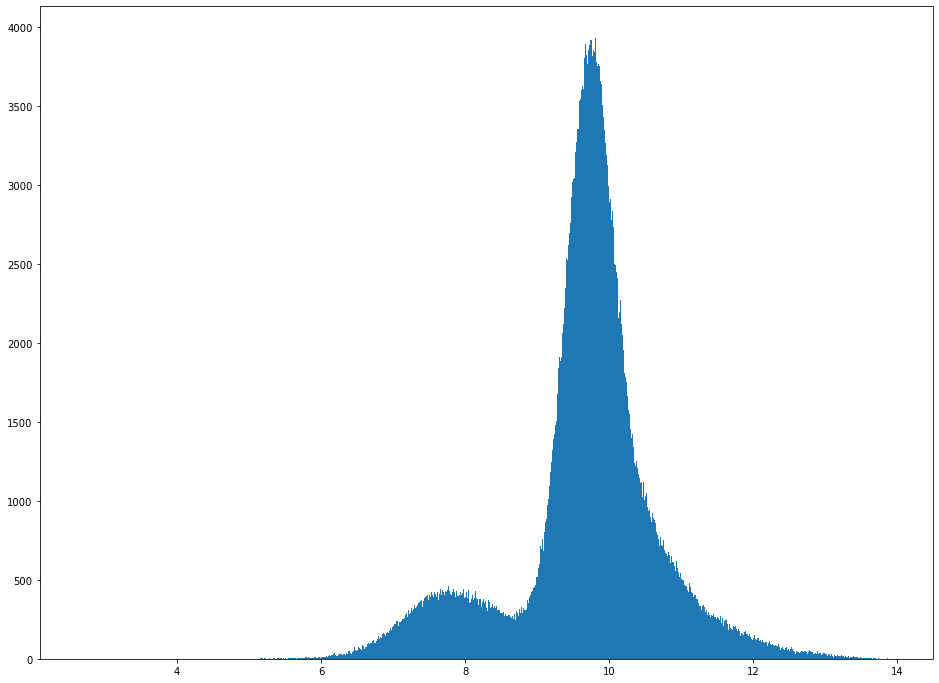

In [92]:
cell_gmm = extract_info(class_probs[1], 2)

7.5附近是比较标准的血细胞  
到了9附近就肯定不是了  

In [117]:
means = cell_gmm.means_
variances = cell_gmm.covariances_

cell_range = hard_range(means[0][0], variances[0][0], means[1][0], variances[1][0])
print(cell_range)

8.058568659565973 9.127656169752223 9.183292046283158 7.707091561464598
[8.058568659565973, 9.127656169752223]


/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


[[1.12736529e+01]
 [2.44478547e-05]
 [8.09833355e+00]]
[0.18044883 0.46803197 0.3515192 ]
[[[1.64642954e-01]]

 [[2.30043230e-04]]

 [[3.97228695e+00]]]


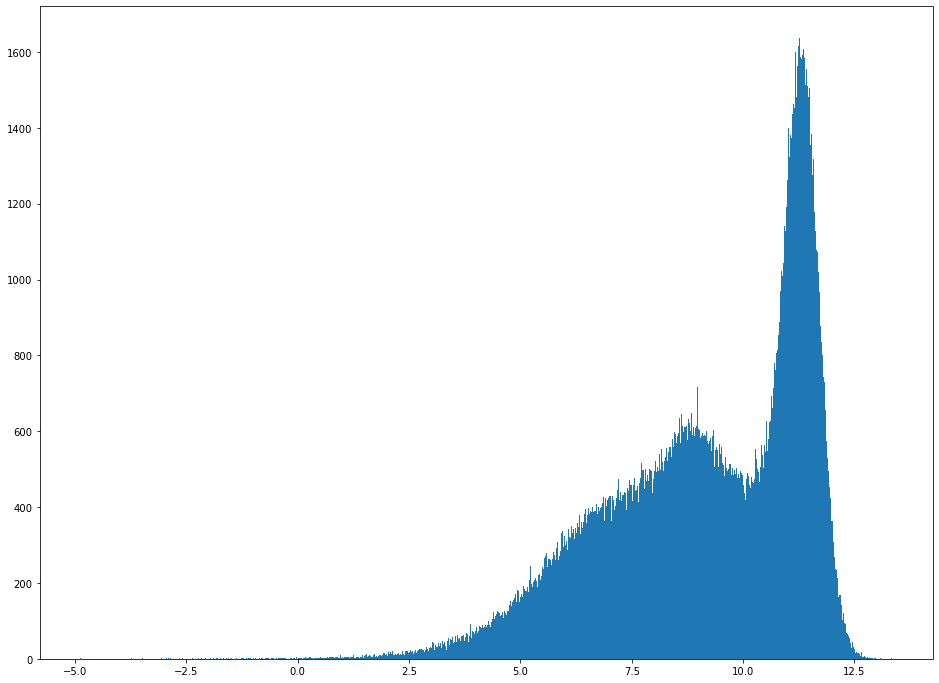

In [93]:
impurity_gmm = extract_info(class_probs[2], 3)

8附近很多都是杂质  
11附近就几乎不是了  


In [118]:
means = impurity_gmm.means_
variances = impurity_gmm.covariances_

impurity_range = hard_range(means[2][0], variances[2][0], means[0][0], variances[0][0])
print(impurity_range)

10.091393246947753 14.077512637092031 10.867890663989279 10.056366287101964
[10.091393246947753, 10.867890663989279]


In [156]:
def check_hard(probs, ranges):
    hard_count = 0
    reason = []
    
    for prob, rang in zip(probs, ranges):
        if prob > rang[0] and prob < rang[1]:
            hard_count += 1
            reason.append(True)
        else:
            reason.append(False)

    if hard_count > 1 or reason[0]:
        return True, reason
    else:
        return False, reason

In [167]:
ranges = [
    chromo_range,
    cell_range,
    impurity_range
]

hard_indexes = []
reasons = []

for i, prob in enumerate(probs):
    hard_flag, reason = check_hard(np.nan_to_num(np.log(-1*prob)), ranges)
    
    if hard_flag:
        hard_indexes.append(i)
        reasons.append(reason)
        
print(len(hard_indexes))

/home/voyager/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


22166


In [170]:
# export hard example filenames
rnd = 1

hard_filenames = []

for i in hard_indexes:
    hard_filenames.append(test_dataset.files[i])
    
with open('hard_round-{}.csv'.format(rnd), mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['filename'])
    
    for filename in hard_filenames:
        csv_writer.writerow([filename])
        

[21.04801955  9.03942495 10.79261922]
[False, True, True]


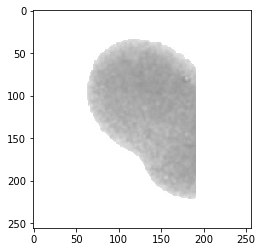

[16.49531051 11.35245429  8.69118793]
[True, False, False]


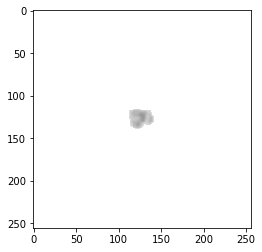

[21.1403182   8.49647938 10.85765982]
[False, True, True]


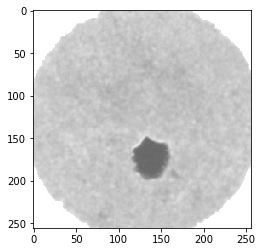

[17.65120897 11.08581198  9.12338113]
[True, False, False]


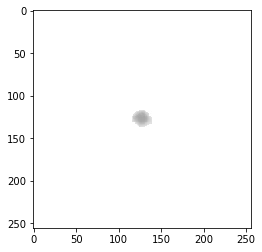

[17.90457804 10.62267957  8.85842219]
[True, False, False]


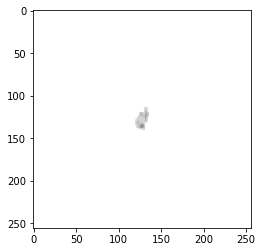

[16.90613308 11.25442028  9.24842773]
[True, False, False]


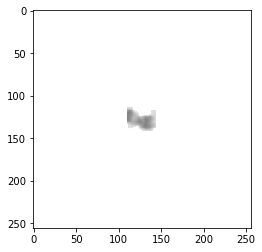

[16.38514726 12.00232917 10.13795047]
[True, False, True]


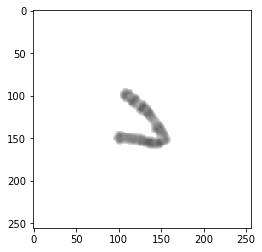

[16.93133329 11.17488459  8.80202791]
[True, False, False]


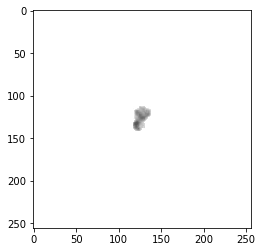

[17.32164351 10.56086294  9.45246247]
[True, False, False]


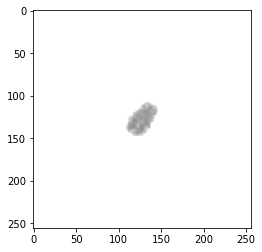

[17.08245715 10.88119095  7.74730017]
[True, False, False]


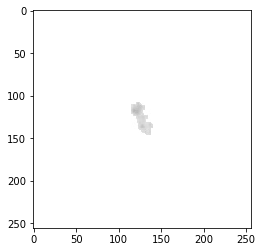

[16.75719194 10.75903993  7.82870135]
[True, False, False]


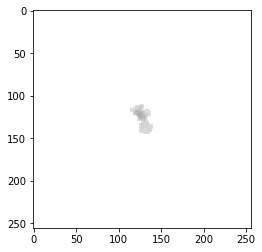

[20.77360972  8.49286054 10.37281093]
[False, True, True]


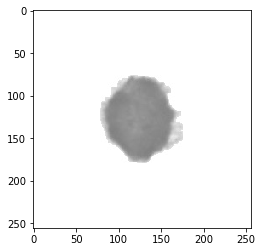

[16.42978834 12.2317743  10.84790691]
[True, False, True]


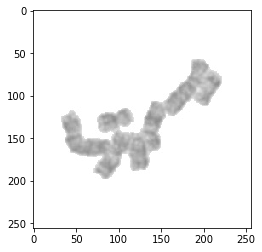

[17.26280167 11.10813423  8.83992358]
[True, False, False]


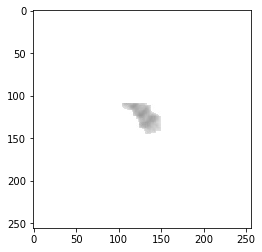

[17.97368428 12.77671494 11.4955445 ]
[True, False, False]


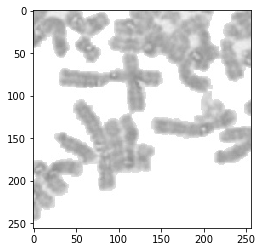

[17.56058278 12.204099   11.24836157]
[True, False, False]


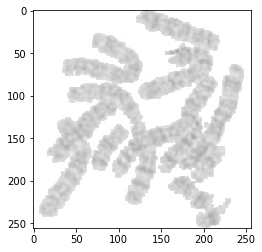

[16.48507848 10.88028577  8.7479351 ]
[True, False, False]


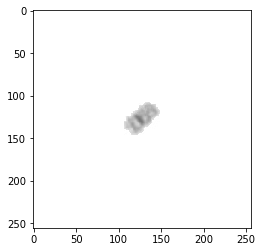

[17.2718644  11.12282845  8.9761928 ]
[True, False, False]


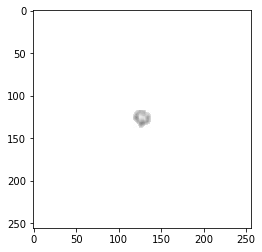

[16.82821091 10.71803766  9.02765648]
[True, False, False]


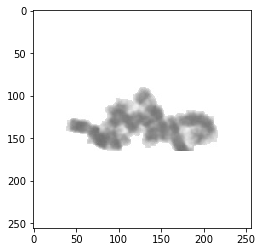

[16.75215666 11.12961461  8.1663517 ]
[True, False, False]


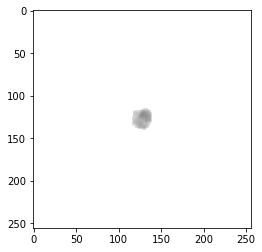

[16.74021671 11.07700257  8.67235775]
[True, False, False]


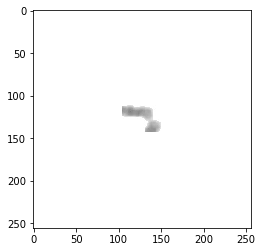

[17.10810972 10.60571176  9.11325888]
[True, False, False]


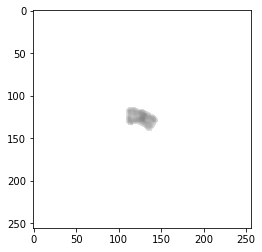

[16.42726847 10.77609444  8.94140683]
[True, False, False]


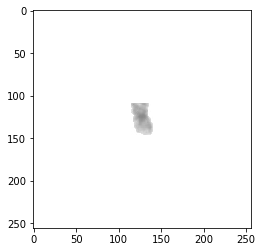

[17.29586288 10.34402126  9.5991186 ]
[True, False, False]


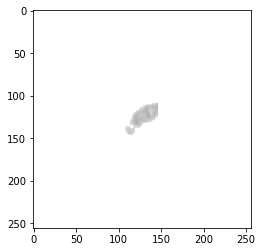

[17.62170613 10.86496663  8.84022996]
[True, False, False]


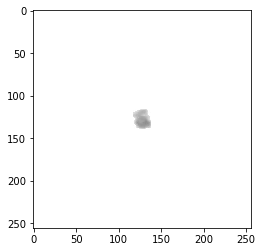

[17.26493547 10.7771636   8.66892996]
[True, False, False]


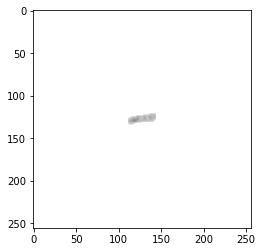

[17.1504243  10.9585344   8.46349949]
[True, False, False]


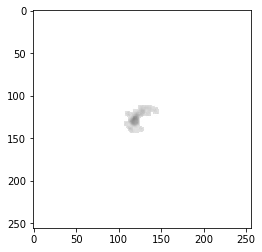

[17.83114802 11.16173588 10.3201289 ]
[True, False, True]


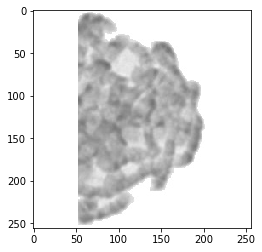

[17.12892731 11.46530689  9.0311841 ]
[True, False, False]


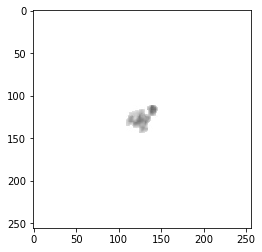

[17.14028829 10.57474949  9.36035551]
[True, False, False]


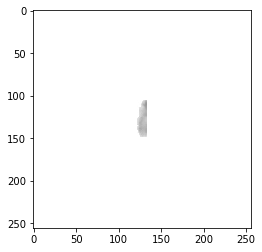

[21.18610757  9.04584259 10.82717602]
[False, True, True]


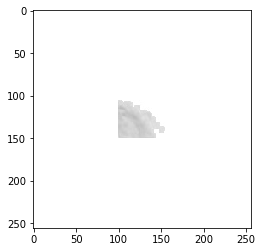

[16.56134822 10.99316499  8.86308081]
[True, False, False]


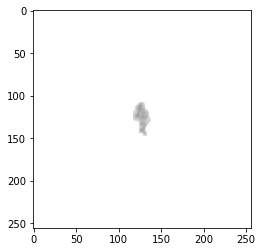

[18.13111324 10.84414457  8.79981976]
[True, False, False]


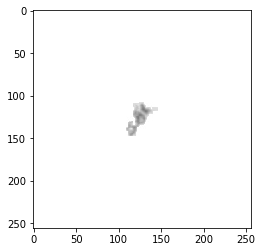

[17.76129525 10.98710666  8.4839666 ]
[True, False, False]


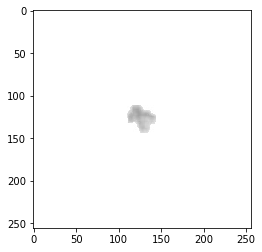

[17.84743755 11.15844539  8.33343417]
[True, False, False]


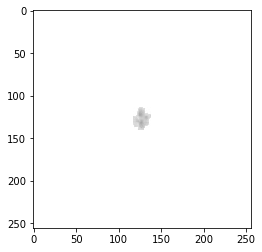

[16.96501688  9.76187833  8.79361716]
[True, False, False]


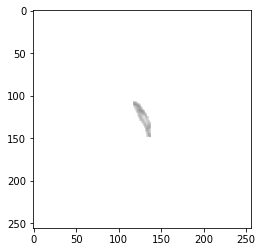

[17.42856205 11.90819179 10.79435569]
[True, False, True]


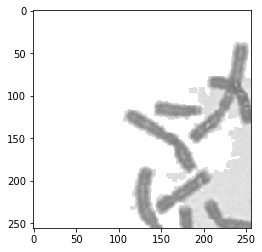

[17.57728685 10.12316168  8.1523172 ]
[True, False, False]


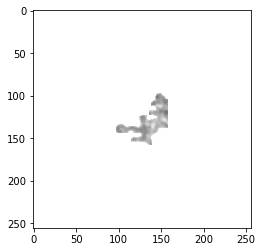

[17.60721884 11.0873915   8.17842556]
[True, False, False]


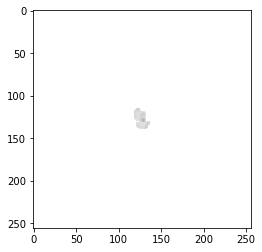

[18.06429709 11.41897112  8.45639739]
[True, False, False]


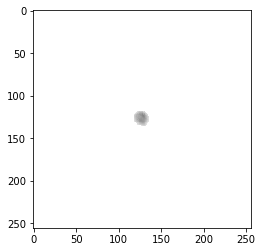

[17.09553765 10.97284018  8.44933011]
[True, False, False]


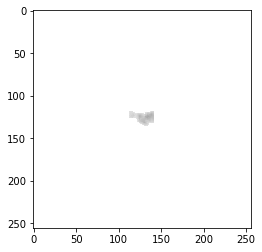

[16.56690484 11.62169697  9.25548562]
[True, False, False]


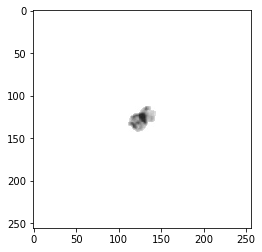

[16.98238281 10.64861722  8.64875998]
[True, False, False]


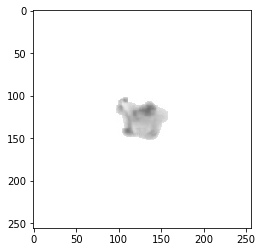

[17.80288305 10.73112773  8.95923777]
[True, False, False]


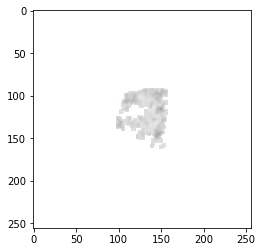

[16.48336118 11.3188871   9.96143242]
[True, False, False]


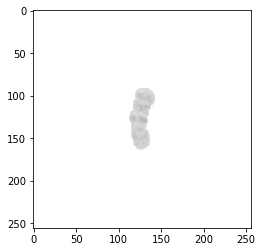

[21.11561239  8.79556186 10.54546261]
[False, True, True]


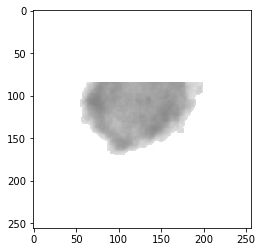

[18.02155119 11.07481176  9.36580025]
[True, False, False]


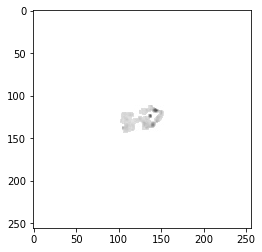

[16.88364369 10.71603338  8.06589001]
[True, False, False]


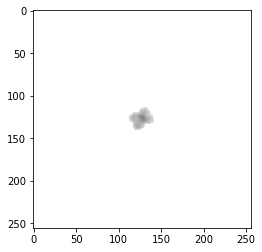

[17.90473932 10.29141213  7.15734665]
[True, False, False]


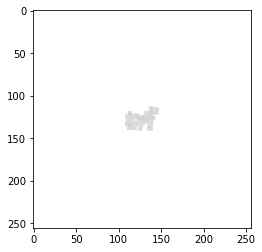

[17.55141959 10.87161948  8.50626329]
[True, False, False]


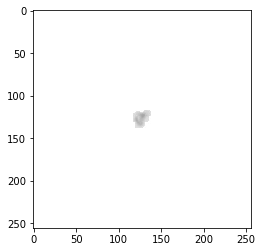

[17.54730047 10.74278156  9.40378607]
[True, False, False]


KeyboardInterrupt: 

In [168]:
for ri, i in enumerate(hard_indexes):
    img = test_dataset[i]
    
    print(np.nan_to_num(np.log(-1*probs[i])))
    print(reasons[ri])
    
    plt.imshow(img.cpu().numpy().transpose((1, 2, 0)))
    plt.show()